# 10.7 Transformer模型
- **目录**
  - 10.7.1 Transformer模型简介
  - 10.7.2 基于位置的前馈网络
  - 10.7.3 残差连接和层规范化
  - 10.7.4 Transformer模型编码器
  - 10.7.5 Transformer模型解码器
  - 10.7.6 Transformer模型训练

- 我们在10.6.2节中比较了卷积神经网络（CNN）、循环神经网络（RNN）和自注意力（self-attention）。
- 值得注意的是，自注意力同时具有**并行计算**和**最短的最大路径长度**这两个优势。
  - 因此，使用自注意力来设计深度架构是很有吸引力的。
- 对比之前仍然**依赖循环神经网络实现输入表示**的自注意力模型，**transformer模型完全基于注意力机制**，没有任何卷积层或循环神经网络层。
- 尽管transformer最初是应用于在文本数据上的序列到序列学习，但现在已经推广到各种现代的深度学习中，例如语言、视觉、语音和强化学习领域。

## 10.7.1 Transformer模型简介

- Transformer作为编码器－解码器架构的一个实例，其整体架构图在 图10.7.1中展示。
- 正如所见到的，transformer是由编码器和解码器组成的。
- 与图10.4.1中基于Bahdanau注意力实现的序列到序列的学习相比，transformer的编码器和解码器是**基于自注意力的模块叠加而成**的，
  - 源（输入）序列和目标（输出）序列的**嵌入（embedding）表示**将加上**位置编码（positional encoding）**，再分别输入到编码器和解码器中。
<center><img src='../img/transformer.svg'/></center>
<center>图10.7.1 transformer架构</center>
- Transformer的编码器是由多个相同的层叠加而成的，每个层都有两个子层（子层表示为$\mathrm{sublayer}$）。
  - 第一个子层是**多头自注意力（multi-head self-attention）池化**；
  - 第二个子层是**基于位置的前馈网络（positionwise feed-forward network）**。
  - 具体来说，在计算编码器的自注意力时，**查询、键和值都来自前一个编码器层的输出**。
  - 受7.6节中残差网络的启发，每个子层都采用了**残差连接（residual connection）**。
  - 在transformer中，对于序列中任何位置的任何输入$\mathbf{x} \in \mathbb{R}^d$，都要求满足$\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便残差连接满足$\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$。
  - 在残差连接的加法计算之后，紧接着应用**层规范化（layer normalization）**。
  - 因此，输入序列对应的每个位置，transformer编码器都将输出一个$d$维表示向量。
- Transformer解码器也是由多个相同的层叠加而成的，并且层中使用了残差连接和层规范化。
  - 除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入了第三个子层，称为**编码器－解码器注意力（encoder-decoder attention）** 层。
  - 在编码器－解码器注意力中，**查询来自前一个解码器层的输出，而键和值来自整个编码器的输出**。
  - 在解码器自注意力中，查询、键和值都来自上一个解码器层的输出(**注：严格来说是来自上一个注意力块的输出**)。
- 但是，解码器中的每个位置只能考虑该位置之前的所有位置。
  - 这种**掩蔽（masked）** 注意力保留了**自回归（auto-regressive）** 属性，确保预测仅依赖于已生成的输出词元。

- 我们已经描述并实现了基于缩放点积多头注意力10.5节和位置编码10.6.3节。
- 接下来，我们将实现transformer模型的剩余部分。

In [109]:
%matplotlib inline
import math
import pandas as pd
import numpy as np ##加上去对数据形状进行探索的工具
import torch
from torch import nn
from d2l import torch as d2l
import os
from icecream import ic

## 10.7.2 基于位置的前馈网络

- 基于位置的前馈网络对序列中的**所有位置的表示进行变换时使用的是同一个多层感知机（MLP）**，这就是称前馈网络是**基于位置的（positionwise）** 的原因。
- 在下面的实现中，输入`X`的形状（批量大小，时间步数或序列长度，隐单元数或特征维度）将被一个两层的感知机转换成形状为（批量大小，时间步数，`ffn_num_outputs`）的输出张量。


In [110]:
#@save
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    '''
    前馈网络有3个参数，最后一个参数决定输出的形状
    3个参数：4,4,8
    '''
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        '''
        参数(4,4)
        '''
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        '''
        参数：4,8
        '''
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        '''
        由里到外的形状变换：(2,3,4)@(4,4)=(2,3,4)@(4,8)=(2,3,8)
        '''
        return self.dense2(self.relu(self.dense1(X)))

- 下面的例子显示，**改变张量的最里层维度的尺寸，会改变成基于位置的前馈网络的输出尺寸**。
- 因为用同一个多层感知机对所有位置上的输入进行变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [111]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0], ffn(torch.ones((2, 3, 4))).shape

(tensor([[ 0.2483,  0.2086, -0.6796,  0.5647,  0.0087,  0.2429, -0.2126,  0.3032],
         [ 0.2483,  0.2086, -0.6796,  0.5647,  0.0087,  0.2429, -0.2126,  0.3032],
         [ 0.2483,  0.2086, -0.6796,  0.5647,  0.0087,  0.2429, -0.2126,  0.3032]],
        grad_fn=<SelectBackward0>),
 torch.Size([2, 3, 8]))

---
- **说明：逐位前馈网络的具体涵义**
  - FFN对输入序列中每个位置的表示向量 **单独、独立** 地进行处理，而**不考虑其他位置的信息**。
    - 这种处理方式意味着，FFN仅对输入序列中每一个位置的特征进行特定的映射变换，而不会涉及序列中其他位置的特征。
  - **逐位置的具体含义**
    - **逐位置独立处理**：
      - 假设输入是一个长度为 $n$ 的序列，每个位置的表示向量是 $\mathbf{x}_i \in \mathbb{R}^d$（表示序列中第 $i$ 个位置的 $d$-维特征向量）。
      - 逐位置的意思是，FFN会分别对每个位置的输入 $\mathbf{x}_i$ 应用相同的前馈网络计算（即相同的权重矩阵和偏置），并输出一个新的表示向量。
      - **关键点**：处理第 $i$ 个位置时，不会使用第 $j$ ($j \neq i$) 个位置的信息。
    - **并行处理**：
      - 虽然每个位置的计算是独立的，但在实现上，由于它们使用相同的权重，可以通过向量化操作（如矩阵乘法）对整个序列同时进行计算，因此计算效率非常高。
    - **输入输出形状**：
      - 输入是一个序列表示矩阵 $\mathbf{X} \in \mathbb{R}^{n \times d}$，其中 $n$ 是序列长度，$d$ 是每个位置的表示向量维度。
      - FFN 会对 $\mathbf{X}$ 的每一行（即每个位置的向量）独立地应用相同的变换，输出一个新的矩阵 $\mathbf{Y} \in \mathbb{R}^{n \times d}$。
    - **逐位置的优点：**
      - **独立性**：每个位置的表示向量独立处理，不掺杂其他位置的信息。这种设计便于模型捕获位置本身的特征，而不依赖于序列上下文。
      - **局部特征增强**：配合多头自注意力机制，FFN可以对每个位置的特征进行非线性变换，从而增强局部特征表示
  - **前馈的定义**
    - **数据流动是单向的**：从输入到输出没有任何回环（不像循环神经网络RNN那样会有时间上的反馈连接）。
    -  **每一层的输出直接传递给下一层**：每一层都对输入进行一次线性变换和非线性激活，然后将结果传递到下一层。
----

## 10.7.3 残差连接和层规范化

- 现在让我们关注图10.7.1中的“**加法和规范化（add&norm）**”组件。
- 正如在本节开头所述，这是由**残差连接**和紧随其后的**层规范化**组成的。两者都是构建**有效的深度架构**的关键。
- 在7.5节解释了在一个小批量的样本内基于批量规范化对数据进行**重新中心化**和**重新缩放**的调整。
- 层规范化和批量规范化的目标相同，但**层规范化是基于特征维度进行规范化**。
 - 尽管批量规范化在计算机视觉中被广泛应用，但**在自然语言处理任务中（输入通常是变长序列）批量规范化通常不如层规范化的效果好。**

- 以下代码**对比不同维度的层规范化和批量规范化的效果**。


In [112]:
## 比较层规范化和批量规范化
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [113]:
## 层归一化(规范化)手工实现
X.mean(dim=-1,keepdims=True),X.std(dim=-1,unbiased=False,keepdims=True),(X-X.mean(-1,keepdims=True))/X.std(dim=-1, unbiased=False,keepdims=True)

(tensor([[1.5000],
         [2.5000]]),
 tensor([[0.5000],
         [0.5000]]),
 tensor([[-1.,  1.],
         [-1.,  1.]]))

In [114]:
## 批量归一化手工实现
X.mean(dim=0,keepdims=True),X.std(dim=0,unbiased=False,keepdims=True),(X-X.mean(0,keepdims=True))/X.std(dim=0, unbiased=False,keepdims=True)

(tensor([[1.5000, 2.5000]]),
 tensor([[0.5000, 0.5000]]),
 tensor([[-1., -1.],
         [ 1.,  1.]]))

-------------
- **说明：LayerNorm与BatchNorm1d两种归一化（规范化）的解释**
- **（1）LayerNorm归一化**

In [115]:
## 测试两种归一化的不同之处
## LayerNorm
N,H,W=2,3,4
t=torch.arange(24.0).reshape(N,H,W)
'''
层归一化LayerNorm的官方文档：
在最后D维上计算平均值和标准差，其中D是normalized_shape的维。
如果elementwise_affine为True，Y和β是可学习的仿射变换参数。
标准差的计算是通过有偏估计器，即torch.std(input, unbiased= False)。
注意pytorch的层归一化使用标准差的有偏估计。
通俗讲：用某维上的数据减去该维的均值，然后除以该维的标准差。
在第3维上归一化。
LayerNorm的参数是张量的某维的大小，本例中的4表示第3维的大小。
'''
## 参数[4]是张量的最后一维，即对张量中所有矩阵的每行进行均值和标准差求解
## 然后再使用均值和标准差对张量进行归一化
ln1 = nn.LayerNorm([4])
t, ln1(t)

(tensor([[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.]],
 
         [[12., 13., 14., 15.],
          [16., 17., 18., 19.],
          [20., 21., 22., 23.]]]),
 tensor([[[-1.3416, -0.4472,  0.4472,  1.3416],
          [-1.3416, -0.4472,  0.4472,  1.3416],
          [-1.3416, -0.4472,  0.4472,  1.3416]],
 
         [[-1.3416, -0.4472,  0.4472,  1.3416],
          [-1.3416, -0.4472,  0.4472,  1.3416],
          [-1.3416, -0.4472,  0.4472,  1.3416]]],
        grad_fn=<NativeLayerNormBackward0>))

- nn.LayerNorm([4])层归一化示意图：

<img src = '../img/10_7_2.png' width=550px height=550px>

In [116]:
## 层归一化的手工实现代码
## 在最后一维上求平均值和标准差
## 即每个矩阵的行均值和有偏标准差
(t-t.mean(-1,keepdims=True))/t.std(axis=-1,unbiased=False,keepdims=True)

tensor([[[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]],

        [[-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416],
         [-1.3416, -0.4472,  0.4472,  1.3416]]])

In [117]:
'''
后两维计算层归一化:
其本质是对张量的每个矩阵分别求均值和有偏标准差，
然后再对每个矩阵分别减去各自的均值再除以各自的标准差。
唯一让人感到困惑的是：为何要使用每一维的大小作为参数，而不是维度作为参数？
如果有维的大小相同，是否会导致计算产生混乱？
'''
ln = nn.LayerNorm([3,4])
ln(t)

tensor([[[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]],

        [[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]]],
       grad_fn=<NativeLayerNormBackward0>)

- nn.LayerNorm([3, 4])层归一化示意图：

<img src = '../img/10_7_3.png' width=550px height=550px>

In [118]:
## 手工实现axis=(-2,-1)与axis=(1,2)功能相同
m=t.mean(dim=(1,2),keepdims=True)
m

tensor([[[ 5.5000]],

        [[17.5000]]])

In [119]:
s=t.std(dim=(1,2),unbiased=False,keepdims=True)
s

tensor([[[3.4521]],

        [[3.4521]]])

In [120]:
(t-m)/s

tensor([[[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]],

        [[-1.5933, -1.3036, -1.0139, -0.7242],
         [-0.4345, -0.1448,  0.1448,  0.4345],
         [ 0.7242,  1.0139,  1.3036,  1.5933]]])

In [121]:
## 各自求两个矩阵的均值和有偏标准差
## 然后再对两个3行4列的矩阵求层归一化
m=t[0].mean()
s=t[0].std(unbiased=False)
(t[0]-m)/s

tensor([[-1.5933, -1.3036, -1.0139, -0.7242],
        [-0.4345, -0.1448,  0.1448,  0.4345],
        [ 0.7242,  1.0139,  1.3036,  1.5933]])

In [122]:
m=t[1].mean()
s=t[1].std(unbiased=False)
(t[1]-m)/s

tensor([[-1.5933, -1.3036, -1.0139, -0.7242],
        [-0.4345, -0.1448,  0.1448,  0.4345],
        [ 0.7242,  1.0139,  1.3036,  1.5933]])

In [123]:
# 如果dim=[2,3,4]
ln = nn.LayerNorm([2,3,4])
ln(t), (t - t.mean())/t.std(unbiased=False)

(tensor([[[-1.6613, -1.5169, -1.3724, -1.2279],
          [-1.0835, -0.9390, -0.7945, -0.6501],
          [-0.5056, -0.3612, -0.2167, -0.0722]],
 
         [[ 0.0722,  0.2167,  0.3612,  0.5056],
          [ 0.6501,  0.7945,  0.9390,  1.0835],
          [ 1.2279,  1.3724,  1.5169,  1.6613]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[-1.6613, -1.5169, -1.3724, -1.2279],
          [-1.0835, -0.9390, -0.7945, -0.6501],
          [-0.5056, -0.3612, -0.2167, -0.0722]],
 
         [[ 0.0722,  0.2167,  0.3612,  0.5056],
          [ 0.6501,  0.7945,  0.9390,  1.0835],
          [ 1.2279,  1.3724,  1.5169,  1.6613]]]))

In [126]:
## 此操作错误
ln = nn.LayerNorm([3])
#ln(t)

- **（2）BatchNorm1d归一化**

In [127]:
'''
BatchNorm1d主要处理:
主要用于处理形状为N, C, L或者N, C的数据，其中N是批量大小，C是通道数，L是特征数。
BatchNorm1d的参数是特征数num_features (int) 或者是输入的通道数。
此处3表示
'''
b=nn.BatchNorm1d(3)
b(t)

tensor([[[-1.2288, -1.0650, -0.9012, -0.7373],
         [-1.2288, -1.0650, -0.9012, -0.7373],
         [-1.2288, -1.0650, -0.9012, -0.7373]],

        [[ 0.7373,  0.9012,  1.0650,  1.2288],
         [ 0.7373,  0.9012,  1.0650,  1.2288],
         [ 0.7373,  0.9012,  1.0650,  1.2288]]],
       grad_fn=<NativeBatchNormBackward0>)

- nn.BatchNorm1d(3)批量归一化示意图：

<img src = '../img/10_7_4.png' width=700px height=700px>


In [128]:
(t-t.mean(axis=(0,2),keepdims=True))/t.std(axis=(0,2),unbiased=False,keepdims=True)

tensor([[[-1.2288, -1.0650, -0.9012, -0.7373],
         [-1.2288, -1.0650, -0.9012, -0.7373],
         [-1.2288, -1.0650, -0.9012, -0.7373]],

        [[ 0.7373,  0.9012,  1.0650,  1.2288],
         [ 0.7373,  0.9012,  1.0650,  1.2288],
         [ 0.7373,  0.9012,  1.0650,  1.2288]]])

In [129]:
t.mean(axis=(0,2))

tensor([ 7.5000, 11.5000, 15.5000])

In [131]:
## N,C,H,W
'''
官方文档例子：
平均和标准偏差在C上求均值和标准差，C是通道维。
BatchNorm2d主要用于处理形状为N, C, H, W的数据，
其中N是批量大小，C是通道数，H和W分别是特征图的高度和宽度。

# With Learnable Parameters
m = nn.BatchNorm2d(100)
# Without Learnable Parameters
m = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = m(input)
'''
N,C,H,W=2,3,4,4
p=torch.arange(96.).reshape(N,C,H,W)
b1=nn.BatchNorm2d(C)
b1(p)

tensor([[[[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]],

         [[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]],

         [[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]]],


        [[[ 0.6752,  0.7161,  0.7570,  0.7979],
          [ 0.8388,  0.8798,  0.9207,  0.9616],
          [ 1.0025,  1.0434,  1.0843,  1.1253],
          [ 1.1662,  1.2071,  1.2480,  1.2889]],

         [[ 0.6752,  0.7161,  0.7570,  0.7979],
          [ 0.8388,  0.8798,  0.9207,  0.9616],
          [ 1.0025,  1.0434,  1.0843,  1.1253],
          [ 1.1662,  1.2071,  1.2480,  1.2889]],

         [[ 0.6752,  0.7161,

- nn.BatchNorm2d(C)归一化，C=3:

<img src = '../img/10_7_5.png' width=800px height=800px>

In [132]:
## 求第2维的均值和标准差
## 即求通道维的均值和标准差
mp=p.mean(axis=(0,2,3),keepdims=True)
sp=p.std(axis=(0,2,3),unbiased=False,keepdims=True)
(p-mp)/sp

tensor([[[[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]],

         [[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]],

         [[-1.2889, -1.2480, -1.2071, -1.1662],
          [-1.1253, -1.0843, -1.0434, -1.0025],
          [-0.9616, -0.9207, -0.8798, -0.8388],
          [-0.7979, -0.7570, -0.7161, -0.6752]]],


        [[[ 0.6752,  0.7161,  0.7570,  0.7979],
          [ 0.8388,  0.8798,  0.9207,  0.9616],
          [ 1.0025,  1.0434,  1.0843,  1.1253],
          [ 1.1662,  1.2071,  1.2480,  1.2889]],

         [[ 0.6752,  0.7161,  0.7570,  0.7979],
          [ 0.8388,  0.8798,  0.9207,  0.9616],
          [ 1.0025,  1.0434,  1.0843,  1.1253],
          [ 1.1662,  1.2071,  1.2480,  1.2889]],

         [[ 0.6752,  0.7161,

In [133]:
## 求第二个维度的均值与标准差(有偏)
p.mean(axis=(0,2,3),keepdims=True), p.std(axis=(0,2,3),unbiased=False,keepdims=True)

(tensor([[[[31.5000]],
 
          [[47.5000]],
 
          [[63.5000]]]]),
 tensor([[[[24.4387]],
 
          [[24.4387]],
 
          [[24.4387]]]]))

- **（3）多维张量的切片机制**

In [134]:
## 对两个矩阵按列进行拼接之后再求均值
t.mean(axis=(0,1))

tensor([10., 11., 12., 13.])

In [135]:
t[:,:,0].mean(),t[:,:,1].mean(),t[:,:,2].mean(),t[:,:,3].mean()

(tensor(10.), tensor(11.), tensor(12.), tensor(13.))

In [136]:
## 对两个矩阵按行进行拼接之后求均值
t.mean(axis=(0,2))

tensor([ 7.5000, 11.5000, 15.5000])

In [137]:
t[:,0,:].mean(),t[:,1,:].mean(),t[:,2,:].mean()

(tensor(7.5000), tensor(11.5000), tensor(15.5000))

In [138]:
## 求两个矩阵的均值
t.mean(axis=(1,2))

tensor([ 5.5000, 17.5000])

In [139]:
## 两种方法的切片结果相同
t[0,:,:].mean(),t[1,:,:].mean(),t[0].mean(),t[1].mean()

(tensor(5.5000), tensor(17.5000), tensor(5.5000), tensor(17.5000))

- 现在可以**使用残差连接和层规范化**来实现`AddNorm`类。
- 暂退法也被作为正则化方法使用。


In [140]:
#@save
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    ## 此处self.dropout(Y) + X是残差连接
    ## ln是层归一化
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

- 残差连接要求两个输入的形状相同，以便**加法操作后输出张量的形状相同**。


In [141]:
## AddNorm不改变输入的形状，正则化后直接输出
## 在两个矩阵上进行归一化，注意参数的[3, 4]用法
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [143]:
## 残差连接与层规范化操作
add_norm(t,t*torch.randn((2,3,4)))

tensor([[[-0.6732, -0.6512, -0.5061,  0.0196],
         [ 0.0143, -1.6198, -0.0327,  1.6421],
         [-0.2442, -0.3338,  0.0679,  2.3171]],

        [[-0.2281, -0.4567,  0.0995, -0.7598],
         [ 2.1054, -0.0769, -0.4490,  1.9216],
         [-1.2570, -0.9626,  0.4260, -0.3623]]],
       grad_fn=<NativeLayerNormBackward0>)

## 10.7.4 Transformer模型编码器

- 有了组成transformer编码器的基础组件，现在可以先**实现编码器中的一个层**。
- 下面的`EncoderBlock`类包含两个子层：
  - 多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。


- transformer的编码器块

In [144]:
## 这段代码比较好理解
class EncoderBlock(nn.Module):
    """transformer编码器块"""
    ## use_bias参数表明是否使用偏置项
    ## 测试参数：24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        ## attention的输出维度应该是(2, 100, 24)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        '''
        FFN的第三个参数ffn_num_outputs与num_hiddens一致，
        决定其输出形状。
        PositionWiseFFN参数：24, 48, 24
        ffn和addnorm2输出形状为：(2, 100, 24)
        '''
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    ## 先将编码器层中的子层串联起来
    def forward(self, X, valid_lens):
        ## QKV都是使用X本身，因此是自注意力模型
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        '''
        输出的形状应该是：(X.shape[0], X.shape[1], num_hiddens)     
        本例中输出的形状为：(2, 100, 24)
        '''
        return self.addnorm2(Y, self.ffn(Y))

- 正如我们所看到的，**transformer编码器中的任何层都不会改变其输入的形状**。


In [145]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
'''
EncoderBlock参数分别对应：
key_size:24, query_size:24, value_size:24, num_hiddens:24,
norm_shape:[100,24], ffn_num_input:24, ffn_num_hiddens:48, 
num_heads:8, dropout:0.5,
'''
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [146]:
## 注意力池化输出形状， 层归一化输出形状
encoder_blk.attention(X, X, X, valid_lens).shape, encoder_blk.addnorm1(X, encoder_blk.attention(X, X, X, valid_lens)).shape

(torch.Size([2, 100, 24]), torch.Size([2, 100, 24]))

- 在实现下面的**transformer编码器**的代码中，堆叠了`num_layers`个`EncoderBlock`类的实例。
- 由于使用的是值范围在$-1$和$1$之间的固定位置编码，因此通过学习得到的输入的**嵌入表示**的值需要先**乘以嵌入维度的平方根进行重新缩放**，然后再与位置编码相加。


In [147]:
#@save
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    '''
    示例参数：200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5
    '''
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        
        '''
        本例的X是(2,100,24)
        pos_encoding的输出(X.shape[0], X.shape[1], num_hiddens)
        本例为:(2,100,24)，此处的24是num_hiddens。
        '''
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        '''
        num_layers:2
        TransformerEncoder的结构由如下代码确定，
        有2层编码器块。
        '''
        
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        '''
        因为位置编码值在-1和1之间，（正弦与余弦值构成）
        因此嵌入值乘以嵌入维度的平方根进行缩放，
        然后再与位置编码相加。
        
        此处是将词元的编码信息和位置信息融合，便于后面进行解码操作。
        注意此处的嵌入维度与隐状态单元数相同，都是num_hiddens
        '''
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            ## 此处保存注意力权重
            self.attention_weights[i] = blk.attention.attention.attention_weights
            #ic(blk.attention.attention.attention_weights.shape)
        return X

---------------------
- **说明：**
- **（1）Transformer模型编码器图解**
<img src = '../img/10_7_6_1.png' width=1000px/>


-  **（2）nn.Embedding的用途**

In [148]:
'''
嵌入编码是需要注意，Embedding的第一个参数必须至少比x的最大值大1。比如
本例x的最大值为97，那么Embedding第一个参数如果小于98，那么调用
embed(x)就会报错。
这个容易理解，x是tokens在词表中的索引，里面的tokens索引必须在词表里存在，
因此词表的大小必须大于token的索引。
'''
torch.set_printoptions(sci_mode=False)
x=torch.randint(1,100,(2,40)).type(torch.long)
embed=nn.Embedding(x.max()+1,24)
embeded = embed(x)

In [149]:
# 嵌入编码后数据特征
embeded.mean()

tensor(0.0056, grad_fn=<MeanBackward0>)

-----------

- 下面我们指定了超参数来**创建一个两层的transformer编码器**。
- Transformer编码器输出的形状是（批量大小，时间步数目，`num_hiddens`）。


In [150]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
## 编码层输出(X.shape[0],X.shape[1],hidden_nums)
## 作为输入的X形状：(2,100)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [151]:
## 位置编码与嵌入表示的均值比较
encoder.pos_encoding(X).mean(), encoder.embedding(torch.ones((2, 100), dtype=torch.long)).mean()

(tensor(1.3383), tensor(-0.0905, grad_fn=<MeanBackward0>))

In [152]:
## 嵌入表示乘以维度的平方根
(encoder.embedding(torch.ones((2, 100), dtype=torch.long))*(24**.5)).mean()

tensor(-0.4432, grad_fn=<MeanBackward0>)

In [153]:
## attention_weights保存两层编码器的自注意力权重，
## 多头自注意力权重的形状在前面已解释
len(encoder.attention_weights),encoder.attention_weights[0].shape

(2, torch.Size([16, 100, 100]))

## 10.7.5 Transformer模型解码器

- 如图10.7.1所示，**transformer解码器也是由多个相同的层组成**。
- 在`DecoderBlock`类中实现的每个层包含了**三个子层**：
  - 解码器自注意力
  - “编码器-解码器”注意力
  - 基于位置的前馈网络。
- 这些子层也都被残差连接和紧随的层规范化围绕。

- 正如在本节前面所述，在掩蔽多头解码器自注意力层（第一个子层）中，查询、键和值都来自上一个解码器层的输出。
- 关于序列到序列模型（sequence-to-sequence model），**在训练阶段，其输出序列的所有位置（时间步）的词元都是已知的**；
- 然而，**在预测阶段，其输出序列的词元是逐个生成的**。 
- 因此，在任何解码器时间步中，只有生成的词元才能用于解码器的自注意力计算中。
- 为了在解码器中保留自回归的属性，其掩蔽自注意力设定了参数`dec_valid_lens`，以便任何查询都只会与解码器中所有已经生成词元的位置（即直到该查询位置为止）进行注意力计算。


In [154]:
class DecoderBlock(nn.Module):
    """
    解码器中第i个块。
    Transformer一般是由多个编码器(层)和解码器(层)构成的。
    测试参数：24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0
    
    """
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i ##第i个解码器注意力块
        ## 解码器的多头自注意力层
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        '''
        ‘编码器-解码器’多头自注意力层，注意其QKV变量来自编码层与上一层的解码层的合并输入。
        Q来自解码层，KV来自编码层。
        注意参数顺序是KQV，通过size定义。
        '''
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        '''
        首先要明白编码层state的来源：
        （1）state[0]:第一个元素是来源于编码器的自注意力，该数据要用于解码器的“编码器-解码器自注意力计算”；
             形状为:前例(2,100,24)或训练时(64,10,32)
        （2）state[1]:来自模型训练时的输入；前例[3,2]    
        （3）state[2]:第三个元素是解码器的输入，也就是解码器中第一个子层多头自注意力的输入。
             前例(2,100,24)或训练时(64,10,32)
        '''
        ## state的第一个元素来自编码器的输出，
        
        enc_outputs, enc_valid_lens = state[0], state[1]
        ''' 
        训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None。
        预测阶段，输出序列是通过词元一个接着一个解码的,因此state[2][self.i]
        包含着直到当前时间步第i个块解码的输出表示。   
        '''
        if state[2][self.i] is None:
            ## is None应该是在训练阶段执行
            ## 形状：(64, 10, 32)
            key_values = X
            # print('1_key_values.shape:',key_values.shape)
        else:
            '''
            else部分应该是在预测阶段执行
            在批量中的每个矩阵纵向拼接，即拼接成更多行，而不是更多列。
            比如2个(1,1,32)拼接成(1,2,32)，其本质就是拼接多个序列的嵌入编码。
            此处1个（小批量的大小）长度为10的序列（即序列有10个词元（可能包含填充词）），
            每个词元使用32位嵌入编码。
            '''
            key_values = torch.cat((state[2][self.i], X), axis=1)
            # print('2_key_values.shape:',key_values.shape)
            
        state[2][self.i] = key_values
        
        '''
        在此处区分是训练还是预测
        '''
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 此处为(64, 10)
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
            #print('training dec_valid_lens shape:', dec_valid_lens.shape)
        else:
            dec_valid_lens = None
        
        ''' 
        自注意力.
        X的形状是(64,10,32),训练数据,掩码机制应该是来源于key_values。
        从前面的代码中可以出，key_values在预测时只保存当前预测输出词元之前的词元自注意力。
        后面的词元因为还没预测出，所以不在key_values里保存。
        '''
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        '''
        编码器－解码器注意力。
        enc_outputs的形状:(batch_size,num_steps,num_hiddens)
        enc_outputs和enc_valid_lens来自编码层.
        Y是Q，来此解码器上一层（掩码多头注意力层）的输出；
        enc_outputs, enc_outputs是K,V。
        '''
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        ## 解码器块有两个输出，一个是经过前馈网络计算后的结果Z，一个是状态变量state
        ## 这两个返回值和本解码器块的forward函数的参数对应，以便多层解码器进行串联调用。
        return self.addnorm3(Z, self.ffn(Z)), state

- 为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，**编码器和解码器的特征维度都是`num_hiddens`。**


In [155]:
'''
 DecoderBlock的参数：
 key_size, query_size, value_size, num_hiddens,
 norm_shape（值为[100, 24]）, ffn_num_input, ffn_num_hiddens,
 num_heads, dropout,layer
'''
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
## valid_lens在前面编码器例子演示时已经定义了tensor([3,2])
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape, decoder_blk(X, state)[1][0].shape, len(decoder_blk(X, state)[1])

(torch.Size([2, 100, 24]), torch.Size([2, 100, 24]), 3)

- 现在我们构建了由`num_layers`个`DecoderBlock`实例组成的完整的**transformer解码器**。
- 最后，通过一个全连接层计算所有`vocab_size`个可能的输出**词元的预测值**。
- 解码器的自注意力权重和编码器解码器注意力权重都被存储下来，方便后面对其进行可视化显示。


In [156]:
class TransformerDecoder(d2l.AttentionDecoder):
    '''    
    '''
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        ## 嵌入层的大小与隐藏层大小一致
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        ## 增加解码器层
        for i in range(num_layers):
            ## add_module函数可以往模型中增加模块
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i)) ##i为注意力块的编号，即第几个块
        self.dense = nn.Linear(num_hiddens, vocab_size)

    '''
        在解码器状态初始化函数的返回结果：编码器输出，
        编码器有效长度，以及新声明的一个list对象。
        
        尤其是第3个返回对象，在解码器中有特殊用途：强制教学。
        注意：enc_outputs来自编码器的输出，enc_valid_lens是在构建模型时的初始化参数。
        
        这个地方不是特别好理解：
        在训练模型时调用d2l.train_seq2seq函数(具体内容可参看9.7.4节)，
        其中代码net(X, dec_input, X_valid_len)的第3个参数。
        在d2l.EncoderDecoder类dec_state = self.decoder.init_state(enc_outputs, *args)的*args传递到此处。
    '''
    def init_state(self, enc_outputs, enc_valid_lens, *args):    
         return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        ## 解码器同样也需要对X进行嵌入编码和位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))        
        ## len(self.blks)列，range(2)行。一个list对象
        ## 用于保存自注意力权重（注意是权重而不是注意力）
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        ## 在此处完成多层解码器的串联
        '''
        解码器的注意力权重_attention_weights的形状是[[None,None],[None,None]]。
        本例中的解码器有2个编码器块，每个块又有两个注意力层。
        比如：self._attention_weights[0][0]表示第1个解码器块的第1层的权重；
        self._attention_weights[0][1]表示第2个解码器块的第1层的权重
        '''
        for i, blk in enumerate(self.blks): #在注意力块上进行迭代，因此i是块索引           
            ## 解码器的输出有两个：X和状态
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        ## 解码器块返回两个值，一个是输出值；另一个是隐状态，本质上是注意力。
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 10.7.6 Transformer模型训练

- 依照transformer架构来实例化编码器－解码器模型。在这里，指定transformer的编码器和解码器都是2层，都使用4头注意力。
- 与9.7.4节类似，为了进行序列到序列的学习，我们在“英语－法语”机器翻译数据集上训练transformer模型。


loss 0.032, 4803.4 tokens/sec on cuda:0


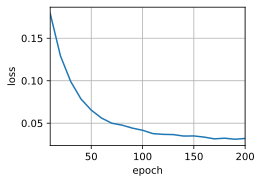

In [157]:
# 模型训练
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

##
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

'''
参数值依次为：184, 32, 32, 32, 32, [32], 32, 64, 4, 2, 0.1
'''
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

'''
参数值依次为：201, 32, 32, 32, 32, [32], 32, 64, 4, 2, 0.1
'''
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [158]:
decoder.attention_weights[0][0].shape,decoder.attention_weights[1][0].shape

(torch.Size([100, 10, 10]), torch.Size([100, 10, 10]))

-----------
**说明：transformer模型训练过程解析**

In [159]:
'''
encoder的自注意力权重的形状很奇怪，这是因为训练数据train_iter小批量
大小并不都是64，最后一个是25。train_iter一共有10个小批量，
前面9个都是64，而最后一个是25。注意力权重的第1维的大小为：批量大小*注意力头数
=25*4=100
'''
net.encoder.attention_weights[0].shape, len(net.encoder.attention_weights)

(torch.Size([100, 10, 10]), 2)

In [160]:
list(iter(train_iter))[8][0].shape,list(iter(train_iter))[9][0].shape

(torch.Size([64, 10]), torch.Size([25, 10]))

In [161]:
##训练数据的大小
64*9+25

601

In [162]:
len(src_vocab),len(tgt_vocab)

(184, 201)

In [163]:
net.decoder.attention_weights[0][0].shape,net.decoder.attention_weights[1][0].shape

(torch.Size([100, 10, 10]), torch.Size([100, 10, 10]))

--------------

- 训练结束后，使用transformer模型**将一些英语句子翻译成法语**，并且计算它们的BLEU分数。


In [164]:
## 开始预测
## 注意预测时，源语言文本是需要进行截断和填充的，而目标语言文本序列不需要
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


- 当进行最后一个英语到法语的句子翻译工作时，让我们**可视化transformer的注意力权重**。
- 编码器自注意力权重的形状为（编码器层数，注意力头数，`num_steps`或查询的数目，`num_steps`或“键－值”对的数目）。


In [165]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

In [166]:
net.encoder.attention_weights[0].shape, torch.cat(net.encoder.attention_weights, 0).shape

(torch.Size([4, 10, 10]), torch.Size([8, 10, 10]))

- 在编码器的自注意力中，查询和键都来自相同的输入序列。
- 因为填充词元是不携带信息的，因此通过指定输入序列的有效长度可以避免查询与使用填充词元的位置计算注意力。
- 接下来，将逐行呈现两层多头注意力的权重。每个注意力头都根据查询、键和值的不同的表示子空间来表示不同的注意力。


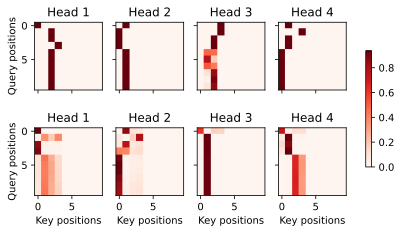

In [167]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

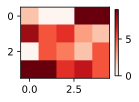

In [168]:
## 矩阵的行为y轴，列为x轴。
## 结合权重的计算过程，可以得知注意力权重热图中y轴为查询，x轴为键
import matplotlib.pyplot as plt
m = torch.randint(0,10,(4,5))
plt.figure(figsize=(2, 2))  # 数字越大，方格越大
plt.imshow(m,  cmap='Reds')
plt.colorbar(shrink=0.6)
plt.show()

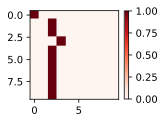

In [169]:
## 直接显示热图
plt.figure(figsize=(2, 2))  # 数字越大，方格越大
plt.imshow(enc_attention_weights.cpu().detach().numpy()[0,0], cmap="Reds")
plt.colorbar(shrink=0.8)
plt.show()

- 为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。
  - 例如，我们用零填充被掩蔽住的注意力权重。
- 值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以**序列开始词元（beginning-of-sequence,BOS）** 打头，再与后续输出的词元共同组成序列。


In [170]:
# i'm home . => je suis chez moi .
# 解码器注意力权重热图
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

----------------
- **说明：解码器注意力权重热图的计算过程**

In [171]:
len(dec_attention_weight_seq)

6

In [86]:
#dec_attention_weight_seq

In [88]:
#dec_attention_weights_2d

In [108]:
#pd.DataFrame(dec_attention_weights_2d[0:32]).fillna(0.0)


In [95]:
#[head[0].tolist()  for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk]

In [96]:
dec_attention_weights_filled.shape

torch.Size([96, 10])

In [65]:
dec_attention_weights.shape

torch.Size([6, 2, 2, 4, 10])

In [98]:
#dec_attention_weights.permute(1, 2, 3, 0, 4).shape, dec_attention_weights.permute(1, 2, 3, 0, 4)

In [100]:
#dec_attention_weights.permute(1, 2, 3, 0, 4)[0].shape,dec_attention_weights.permute(1, 2, 3, 0, 4)[0]

In [104]:
p = [[1],[2,3,4,5,6]]
pd.DataFrame(p)

,0,1,2,3,4
0,1,NaN,NaN,NaN,NaN
1,2,3.0,4.0,5.0,6.0


In [103]:
pd.DataFrame(p).fillna(0.0)

,0,1,2,3,4
0,1,0.0,0.0,0.0,0.0
1,2,3.0,4.0,5.0,6.0


In [106]:
pd.DataFrame(p).fillna(0.0).values

array([[1., 0., 0., 0., 0.],
       [2., 3., 4., 5., 6.]])

In [107]:
torch.tensor(pd.DataFrame(p).fillna(0.0).values)

tensor([[1., 0., 0., 0., 0.],
        [2., 3., 4., 5., 6.]], dtype=torch.float64)

--------

- 由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算。


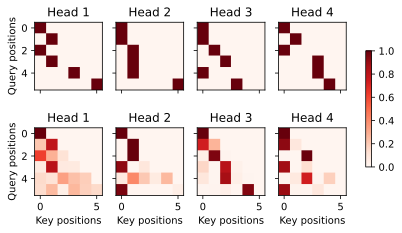

In [172]:
# Plus one to include the beginning-of-sequencetoken
# i'm home . => je suis chez moi .
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [69]:
dec_self_attention_weights[:, :, :, :6].shape,len(translation.split()) + 1

(torch.Size([2, 4, 6, 6]), 6)

- 与编码器的自注意力的情况类似，通过指定输入序列的有效长度，**输出序列的查询不会与输入序列中填充位置的词元进行注意力计算**。


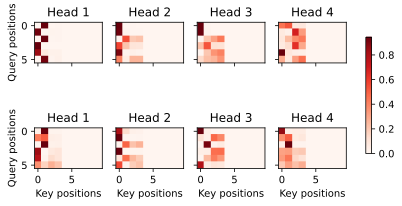

In [173]:
# i'm home . => je suis chez moi .
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

- 尽管transformer架构是为了“序列到序列”的学习而提出的，但正如我们将在本书后面提及的那样，transformer编码器或transformer解码器通常被**单独用于不同的深度学习任务**中。

## 小结

* transformer是编码器－解码器架构的一个实践，尽管在实际情况中编码器或解码器可以单独使用。
* 在transformer中，多头自注意力用于表示输入序列和输出序列，不过解码器必须通过掩蔽机制来保留自回归属性。
* transformer中的残差连接和层规范化是训练非常深度模型的重要工具。
* transformer模型中基于位置的前馈网络使用同一个多层感知机，作用是对所有序列位置的表示进行转换。

----
- **说明：unpacking解包与packing打包**
  - 在函数定义中，`*args` 是一种反向的解包机制。
  - 它将调用函数时传入的多个位置参数 **收集（pack）** 到一个元组中。
  - 从语法上看，定义中使用 `*args` 的行为是 **打包（packing）**，而调用中使用 `*args` 是 **解包（unpacking）**。
  - 在 `func(1, 2, 3)` 中，`*args` 将多个参数 **打包** 成一个元组 `(1, 2, 3)`。
  - 在 `func(*values)` 中，`*values` 将元组 `(4, 5, 6)` **解包** 成独立的参数。

In [79]:
def func(*args):
    print(args)

func(1, 2, 3)  # args 被打包成 (1, 2, 3)

# 反过来解包
values = (4, 5, 6)
func(*values)  # 等价于调用 func(4, 5, 6)

(1, 2, 3)
(4, 5, 6)


In [80]:
def func2(a,b,*args):
    print('a:',a,'b:',b,'c:',c)
a,b,c=1,2,3
func2(a,b,c)

a: 1 b: 2 c: 3


In [81]:
##解包机制有点让人费解:即便调用函数func2时没有将c传递进去，函数仍会得到该参数的值
func2(a,b)

a: 1 b: 2 c: 3


-----------